In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tutorial_path = "drive/MyDrive/"
dependencies = f'{tutorial_path}dependencies/'

In [ ]:
import pandas as pd

# Pull in the score and listen to it a bit
annotations = pd.read_csv(f'{dependencies}Prokofiev Toccata/Dossin07_annotations.txt', sep='\t', header=None)

annotations

,0,1,2
0,10.227554,10.227554,"db,2/4,-1"
1,10.793793,10.793793,b
2,11.363237,11.363237,db
3,11.934817,11.934817,b
4,12.516013,12.516013,db
...,...,...,...
447,264.842684,264.842684,db
448,265.334136,265.334136,b
449,266.090037,266.090037,db
450,266.603017,266.603017,b


<Axes: >

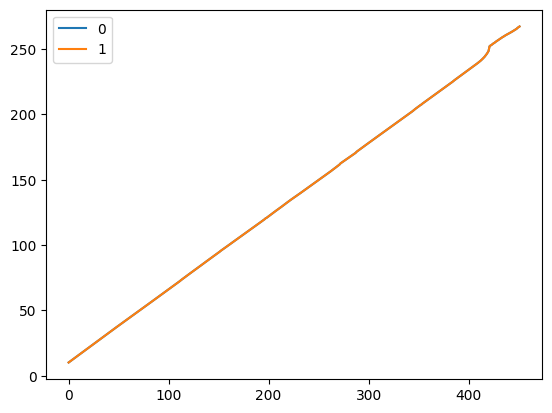

In [ ]:
import matplotlib.pyplot as plt

annotations.plot()

<Axes: >

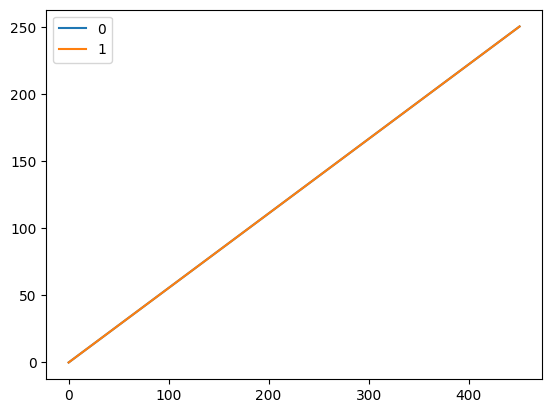

In [ ]:
unperformed_annotations = pd.read_csv(f'{dependencies}Prokofiev Toccata/midi_score_annotations.txt', sep='\t', header=None)

unperformed_annotations.plot()

<Axes: >

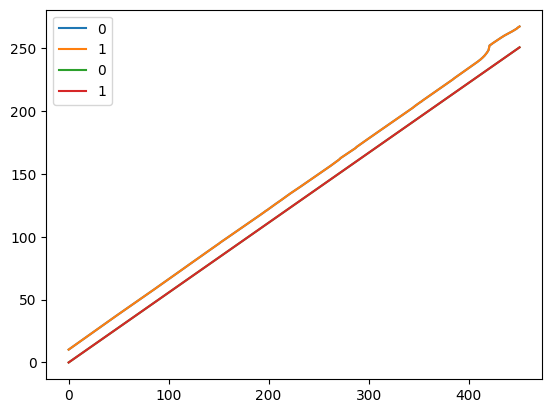

In [ ]:
ax = annotations.plot()
unperformed_annotations.plot(ax=ax)

In [ ]:
annotations[1] = annotations[1].shift(-1, fill_value = 0)

In [ ]:
annotations

,0,1,2
0,10.227554,10.793793,"db,2/4,-1"
1,10.793793,11.363237,b
2,11.363237,11.934817,db
3,11.934817,12.516013,b
4,12.516013,13.087594,db
...,...,...,...
447,264.842684,265.334136,db
448,265.334136,266.090037,b
449,266.090037,266.603017,db
450,266.603017,267.146751,b


In [ ]:
timing = (annotations[1] - annotations[0]) * (annotations[1] - annotations[0] > 0).astype(float)

<Axes: title={'center': 'Tempo Curve: Prokofiev Toccata'}, xlabel='Beat', ylabel='Sec/beat'>

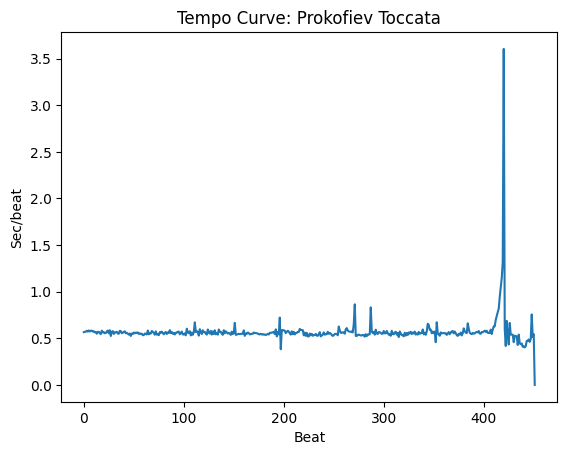

In [ ]:
timing.plot(title="Tempo Curve: Prokofiev Toccata", xlabel="Beat", ylabel="Sec/beat")